<hr style='border-top:4px solid #1F77B4;'>
<h2><span style="color: #1F77B4; font-size: 40px">Chapitre 7</span></h2>
<h1><span style="color: #1F77B4; font-size: 60px">Auto-encodeurs</span></h1>
<hr style='border-top:4px solid #1F77B4;'>

### Importation des bibliothèques

In [1]:
import numpy                     as np
import tensorflow                as tf
from tensorflow.keras.layers     import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models     import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses     import binary_crossentropy
from tensorflow.keras.metrics    import Mean
from tensorflow.keras            import layers
from tensorflow.keras            import ops
from tensorflow.keras.datasets   import mnist
import matplotlib.pyplot         as plt
from sklearn.metrics             import mean_squared_error
from IPython.display             import HTML
import os
import random

<hr style='border-top:4px solid #1F77B4;'>

In [2]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # Configuration TensorFlow pour la reproductibilité
    tf.config.experimental.enable_op_determinism()

In [3]:
def save_figure(fig, path):
    # Extraire le répertoire du chemin donné
    directory = os.path.dirname(path)
    
    # Créer le répertoire s'il n'existe pas
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Sauvegarder dans plusieurs formats
    fig.savefig(f"{path}.pdf", format="pdf", bbox_inches='tight')
    fig.savefig(f"{path}.png", format="png", bbox_inches='tight', dpi=300)
    fig.savefig(f"{path}.jpg", format="jpg", bbox_inches='tight', dpi=300)

In [4]:
def plot_results(original, reconstructed):
    # Affiche les images originales, reconstruites et les erreurs de reconstruction
    
    n = 4  # Nombre d'images à afficher
    # Créer une figure avec une taille adaptée
    fig = plt.figure(figsize=(10, 6))
    
    for i in range(n):
        # Images originales
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            plt.text(-10, 14, '(a)', color='blue', fontsize=16, 
                     fontweight='bold', family='serif', va='center_baseline')
       
        # Images reconstruites
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            plt.text(-10, 14, '(b)', color='blue', fontsize=16, 
                     fontweight='bold', family='serif', va='center_baseline')
            
        # Erreurs de reconstruction
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(np.abs(original[i] - reconstructed[i]).reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            plt.text(-10, 14, '(c)', color='blue', fontsize=16, 
                     fontweight='bold', family='serif', va='center_baseline')
    
    return fig

<hr style='border-top:4px solid #1F77B4;'>

### Configuration initiale des graines

In [5]:
# Configuration initiale des graines
set_seeds(42)

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 7.1 : Lecture et prétraîtement des données MNIST</h3>

In [6]:
from keras.datasets import mnist

# Chargement des données MNIST (images de chiffres manuscrits 28x28)
# Les étiquettes (_) ne sont pas utilisées car l'entraînement est non supervisé 
(x_train, _), (x_test, _) = mnist.load_data()

# Normalisation des pixels entre 0 et 1 (valeurs initialement entre 0 et 255)
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.

# Applatissement des images 2D (28x28) en un vecteur 1D de 784 éléments
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat  = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(f"Dimensions des données d'entraînement: {x_train.shape}")
print(f"Dimensions des données de test: {x_test.shape}")

Dimensions des données d'entraînement: (60000, 28, 28)
Dimensions des données de test: (10000, 28, 28)


<h3><span style="font-size: 30px">🎴</span> Figure 7.5 : Échantillons de la base de données MNIST</h3>

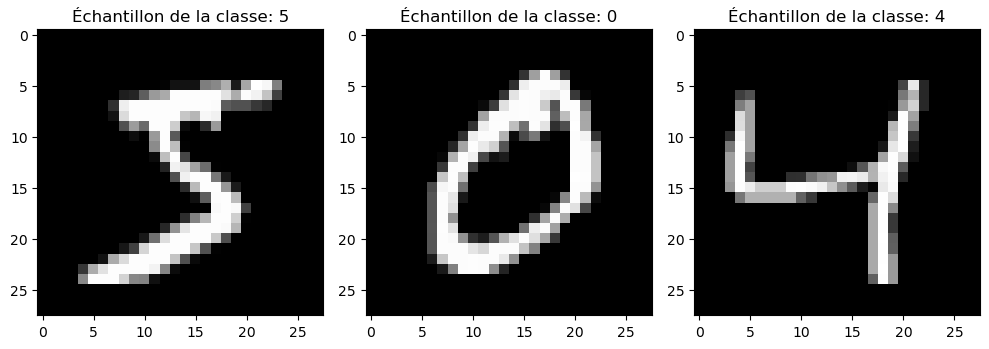

In [7]:
import matplotlib.pyplot as plt

# Chargement des données MNIST (images de chiffres manuscrits 28x28) 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalisation des pixels entre 0 et 1 (valeurs initialement entre 0 et 255)
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.

# Affichage 3 échantillons
fig = plt.figure(figsize=(10, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)  # 1 ligne, 3 colonnes, position i+1
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Échantillon de la classe: {y_train[i]}")  # Utilise l'étiquette réelle
    plt.axis('on')  # Garder les axes visibles comme dans votre exemple

# Optimiser l'affichage
plt.tight_layout()

# Afficher la figure
plt.show()

# Sauvegarder la figure
save_figure(fig, "Figures/Figure_7.5/Chap7_Figure_7.5")

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 7.2 : Définition de l'architecture de l'autoencodeur (AE)</h3>

In [8]:
def create_simple_autoencoder():
    # Définition de l'architecture de l'auto-encodeur. 
    # Le nom du modèle "simple_ae"
    # 1. Entrée : vecteur de 784 dimensions (images 28x28 aplaties)   
    input_img = Input(shape=(784,))

    # 2. Couche d'encodage : réduit la dimension à 128 
    encoded = Dense(128, activation='relu')(input_img)

    # 3. Couche de décodage : reconstruit les 784 dimensions
    decoded = Dense(784, activation='sigmoid')(encoded)

    # Création du modèle auto-encodeur complet reliant l'entrée à la sortie reconstruite
    autoencoder = Model(input_img, decoded, name = "simple_ae")

    # Compilation du modèle avec l'optimiseur Adam et la fonction de perte binaire
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

    return autoencoder

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 7.3 : Entraînement et utilisation de l'autoencodeur (AE)</h3>

In [9]:
tf.keras.backend.clear_session()

In [10]:
# Création et entraînement du modèle AE
simple_ae = create_simple_autoencoder()
simple_ae.fit(x_train_flat, x_train_flat,
              epochs=30,
              batch_size=256,
              shuffle=True,
              validation_data=(x_test_flat, x_test_flat))

# Reconstruction des images du jeu de test
decoded_imgs_simple = simple_ae.predict(x_test_flat)

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3076 - val_loss: 0.1342
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1255 - val_loss: 0.1027
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1000 - val_loss: 0.0889
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0878 - val_loss: 0.0812
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0809 - val_loss: 0.0768
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0768 - val_loss: 0.0740
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0742 - val_loss: 0.0722
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0724 - val_loss: 0.0709
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0712 - val_loss: 0.0699
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0703 - val_loss: 0.0692
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0696 - val_loss: 0.0686
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [11]:
simple_ae.summary() 

Model: "simple_ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 604,850 (2.31 MB)

 Trainable params: 201,616 (787.56 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 403,234 (1.54 MB)

<h3><span style="font-size: 30px">🎴</span> Figure 7.6 : Échantillons de la base de données MNIST : (a) images originales, (b) images reconstruites à partir d'une représentation latente de dimension \( 128 \), et (c) cartes d'erreur de reconstruction</h3>

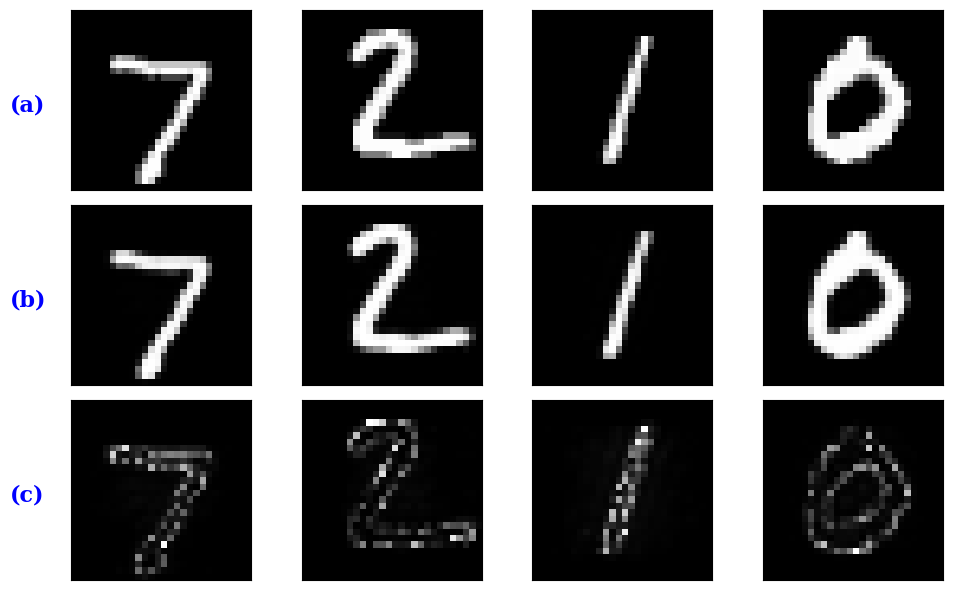

In [12]:
# Tracer et récupérer la figure
fig = plot_results(x_test_flat, decoded_imgs_simple)

# Optimiser l'affichage
plt.tight_layout()

# Afficher la figure
plt.show()

# Sauvegarder la figure
save_figure(fig, "Figures/Figure_7.6/Chap7_Figure_7.6")

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 7.4 : Définition de l'architecture de l'autoencodeur 784-128-2-128-784</h3>

In [13]:
def create_simple_autoencoder_2d():
    set_seeds(42)
    
    # Définition de l'architecture 784-128-2-128-784
    # Le nom du modèle "simple_ae_2d"
    input_img = Input(shape=(784,))
    
    # Encodeur
    encoded_layer1 = Dense(128, activation='relu')(input_img)
    encoded_layer2 = Dense(2)(encoded_layer1)  # Espace latent 2D
    
    # Décodeur
    decoded_layer1 = Dense(128, activation='relu')(encoded_layer2)
    decoded_layer2 = Dense(784, activation='sigmoid')(decoded_layer1)
    
    # Modèles
    autoencoder = Model(input_img, decoded_layer2, name="simple_ae_2d")
    encoder = Model(input_img, encoded_layer2, name="encoder_2d")
    
    return autoencoder, encoder

<h3><span style="font-size: 30px">🎴</span> Figure 7.7 : Échantillons de la base de données MNIST :
		(a) images originales, (b) images reconstruites à partir d'une représentation latente de dimension (128), et (c) cartes d'erreur de reconstruction.</h3>

In [14]:
tf.keras.backend.clear_session()

In [15]:
# Création des modèles
autoencoder, encoder = create_simple_autoencoder_2d()

# Affichage de l'architecture
print("Architecture de l'auto-encodeur:")
autoencoder.summary()

print("\nArchitecture de l'encodeur:")
encoder.summary()

# Compilation et entraînement
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

print("\nEntraînement du modèle...")
history = autoencoder.fit(x_train_flat, x_train_flat,
                         epochs=50,
                         batch_size=256,
                         shuffle=True,
                         validation_data=(x_test_flat, x_test_flat),
                         verbose=1)

# Encodage des images de test dans l'espace latent 2D
print("\nEncodage des images de test...")
encoded_imgs = encoder.predict(x_test_flat)

# Reconstruction des images de test
print("Reconstruction des images de test...")
decoded_imgs = autoencoder.predict(x_test_flat)

# Affichage des résultats
print(f"\nFormes des données:")
print(f"Images originales: {x_test.shape}")
print(f"Espace latent 2D: {encoded_imgs.shape}")
print(f"Images reconstruites: {decoded_imgs.shape}")

Architecture de l'auto-encodeur:


Model: "simple_ae_2d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,258 (790.07 KB)

 Trainable params: 202,258 (790.07 KB)

 Non-trainable params: 0 (0.00 B)


Architecture de l'encodeur:


Model: "encoder_2d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,738 (393.51 KB)

 Trainable params: 100,738 (393.51 KB)

 Non-trainable params: 0 (0.00 B)


Entraînement du modèle...
Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3586 - val_loss: 0.2357
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2331 - val_loss: 0.2211
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2194 - val_loss: 0.2119
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2112 - val_loss: 0.2067
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2066 - val_loss: 0.2033
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2035 - val_loss: 0.2009
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2012 - val_loss: 0.1992
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1995 - val_loss: 0.1979
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1982 - val_loss: 0.1967
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1971 - val_loss: 0.1957
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1961 - val_loss: 0.1949
Epoch 12/50
235/235 ━━━━━

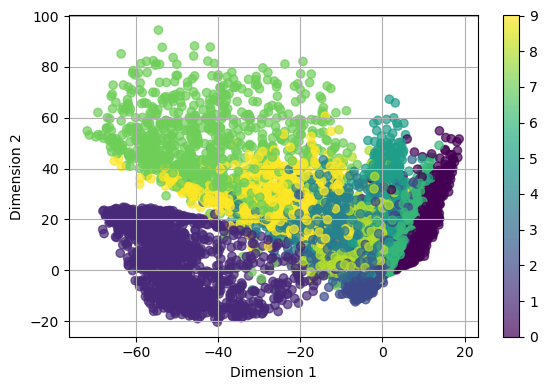

In [16]:
# Visualisation de l'espace latent
fig = plt.figure(figsize=(6, 4))
scatter = plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)

# Optimiser l'affichage
plt.tight_layout()

# Afficher la figure
plt.show()

# Sauvegarder la figure
save_figure(fig, "Figures/Figure_7.7/Chap7_Figure_7.7")

<hr style='border-top:4px solid #1F77B4;'>

# Auto-encodeurs débruiteurs (DAE)

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 7.5 : Préparation des données par l'ajout de bruit gaussien</h3>

In [17]:
# Fonction pour ajouter du bruit gaussien à une image normalisée entre 0 et 1
def add_noise(x, noise_factor=0.5):
    noisy_x = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    return np.clip(noisy_x, 0., 1.)

# Préparation des versions bruitées des données d'entraînement et de test
x_train_noisy = add_noise(x_train_flat)
x_test_noisy  = add_noise(x_test_flat)

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 7.6 : Implémentation du modèle DAE</h3>

In [18]:
# Création d'un autoencodeur simple (structure définie dans create_simple_autoencoder)
denoising_ae = create_simple_autoencoder()

# Entraînement de l'autoencodeur débruiteur :
# Entrée : les images bruitées
# Cible  : les images d'origine (propres)
# L'auto-encodeur apprend donc à reconstruire une image propre à partir d'une entrée bruitée.
denoising_ae.fit(x_train_noisy, x_train_flat, 
                 epochs=30, 
                 batch_size=256, 
                 shuffle=True,
                 validation_data=(x_test_noisy, x_test_flat))

# Utilisation du modèle entraîné pour reconstruire les images originales à partir de leurs versions bruitées.
decoded_imgs_denoising = denoising_ae.predict(x_test_noisy)

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3184 - val_loss: 0.1721
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1641 - val_loss: 0.1428
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1401 - val_loss: 0.1284
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1275 - val_loss: 0.1220
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1218 - val_loss: 0.1184
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1184 - val_loss: 0.1163
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1163 - val_loss: 0.1147
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1147 - val_loss: 0.1136
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1135 - val_loss: 0.1127
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1126 - val_loss: 0.1121
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1118 - val_loss: 0.1115
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

<h3><span style="font-size: 30px">🎴</span> Figure 7.9 : Échantillons de la base de données MNIST : (a) images d'entrée bruitées, (b) reconstructions générées par le DAE, et (c) cartes d'erreur de reconstruction</h3>

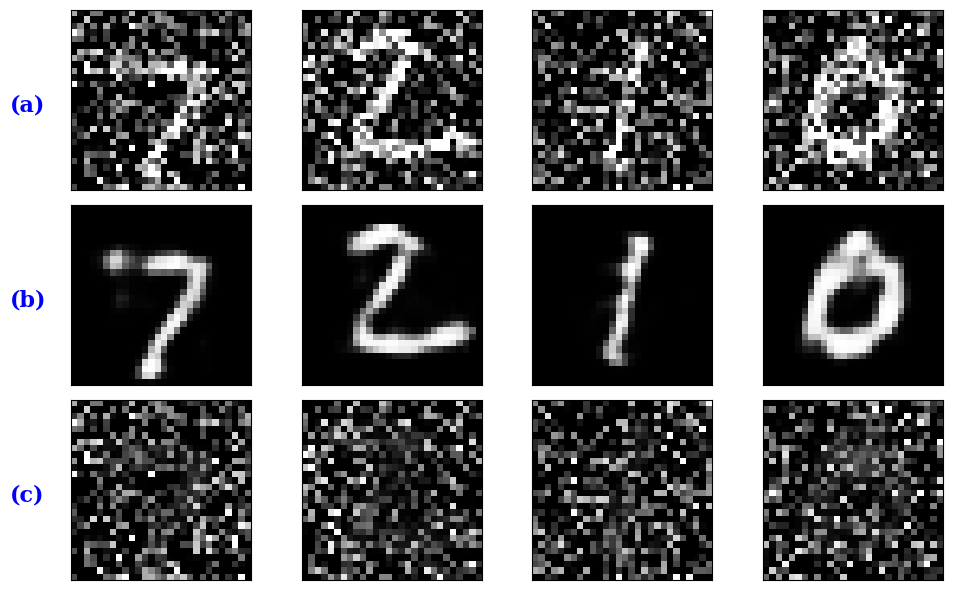

In [19]:
# Tracer et récupérer la figure
fig = plot_results(x_test_noisy, decoded_imgs_denoising)

# Optimiser l'affichage
plt.tight_layout()

# Afficher la figure
plt.show()

# Sauvegarder la figure
save_figure(fig, "Figures/Figure_7.9/Chap7_Figure_7.9")

<hr style='border-top:4px solid #1F77B4;'>

# Auto-encodeurs variationnels (VAE)

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 7.7 : Implémentation de l'astruce de reparamétrisation</h3>

In [20]:
class Sampling(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = tf.keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = tf.keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 7.8 : Création de l'encodeur du VAE</h3>

In [21]:
tf.keras.backend.clear_session()

In [22]:
def create_vae_encoder(latent_dim=2):
    # Création de l'encodeur du VAE
    # Définition de l'encodeur
    encoder_inputs = Input(shape=(28, 28, 1))  # Entrée: images MNIST

    # Extraction des caractéristiques avec des couches convolutionnelles
    conv1 = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    conv2 = Conv2D(64, 3, activation="relu", strides=2, padding="same")(conv1)
    flatten = Flatten()(conv2)  # Aplatissement des caractéristiques
    dense = Dense(16, activation="relu")(flatten)  # Réduction de dimensionnalité

    # Paramètres de la distribution latente
    z_mean = Dense(latent_dim, name="z_mean")(dense)
    z_log_var = Dense(latent_dim, name="z_log_var")(dense)

    # Échantillonnage dans l'espace latent
    z = Sampling()([z_mean, z_log_var])

    # Création du modèle d'encodeur du VAE
    vae_encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="vae_encoder")
    
    return vae_encoder

In [23]:
# Création de l'encodeur
latent_dim = 2
encoder = create_vae_encoder(latent_dim)

# Affichage de l'architecture
encoder.summary() 

Model: "vae_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 7.9 : Création du décodeur du VAE</h3>

In [24]:
tf.keras.backend.clear_session()

In [25]:
def create_vae_decoder(latent_dim=2):
    # Création du décodeur du VAE
    # Définition du décodeur
    latent_inputs = Input(shape=(latent_dim,))  # Entrée: vecteurs de l'espace latent

    # Projection et reshaping pour préparer la déconvolution
    dense = Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    reshape = Reshape((7, 7, 64))(dense)  # Transformation en feature maps 3D

    # Déconvolutions pour reconstruire l'image
    conv_transpose1 = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(reshape)
    conv_transpose2 = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(conv_transpose1)

    # Couche de sortie avec activation sigmoid pour générer des pixels entre 0 et 1
    decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(conv_transpose2)

    # Création du modèle de décodeur
    vae_decoder = Model(latent_inputs, decoder_outputs, name="vae_decoder")
    
    return vae_decoder

In [26]:
# Création du décodeur
decoder = create_vae_decoder(latent_dim)

# Affichage du résumé de l'architecture
decoder.summary()

Model: "vae_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 7.10 : Implémentation de la classe VAE et de sa fonction d'entraînement</h3>

In [27]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
        self.kl_loss_tracker = Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 7.11 : Compilation et entraînement du modèle VAE</h3>

#### Redimensionnement des données d'entraînement pour l'entrée du modèle (ajout de la dimension canal) au format 2D avec canal (28, 28, 1)

In [28]:
# Redimensionnement des données d'entraînement pour l'entrée du modèle (ajout de la dimension canal)
x_train_reshaped = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test_reshaped  = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [29]:
# Création de l'instance VAE avec l'encodeur et le décodeur
vae = VAE(encoder, decoder)  
vae.compile(optimizer=Adam()) 

# Entraînement du modèle
vae.fit(x_train_reshaped, epochs=30, batch_size=128)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - kl_loss: 1.7508 - loss: 258.0942 - reconstruction_loss: 256.3435
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - kl_loss: 4.7261 - loss: 168.5303 - reconstruction_loss: 163.8042
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - kl_loss: 5.2111 - loss: 161.5737 - reconstruction_loss: 156.3626
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - kl_loss: 5.4788 - loss: 158.5588 - reconstruction_loss: 153.0800
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - kl_loss: 5.6118 - loss: 156.8398 - reconstruction_loss: 151.2279
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - kl_loss: 5.7221 - loss: 155.5831 - reconstruction_loss: 149.8610
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - kl_loss: 5.7968 - loss: 154.5919 - reconstruction_loss: 148.7951
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - kl_loss: 5.8831 - loss: 153.8147 - reconstruction_loss: 147.9315
Epoch 9/30
469/469 ━━━━━━━━━━━━━

In [30]:
# Prédictions
decoded_imgs_vae = vae.predict(x_test_reshaped)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


<h3><span style="font-size: 30px">🎴</span> Figure 7.13 : Échantillons de la base de données MNIST : (a) images originales, (b) reconstructions générées par le VAE, et (c) cartes d'erreur de reconstruction</h3>

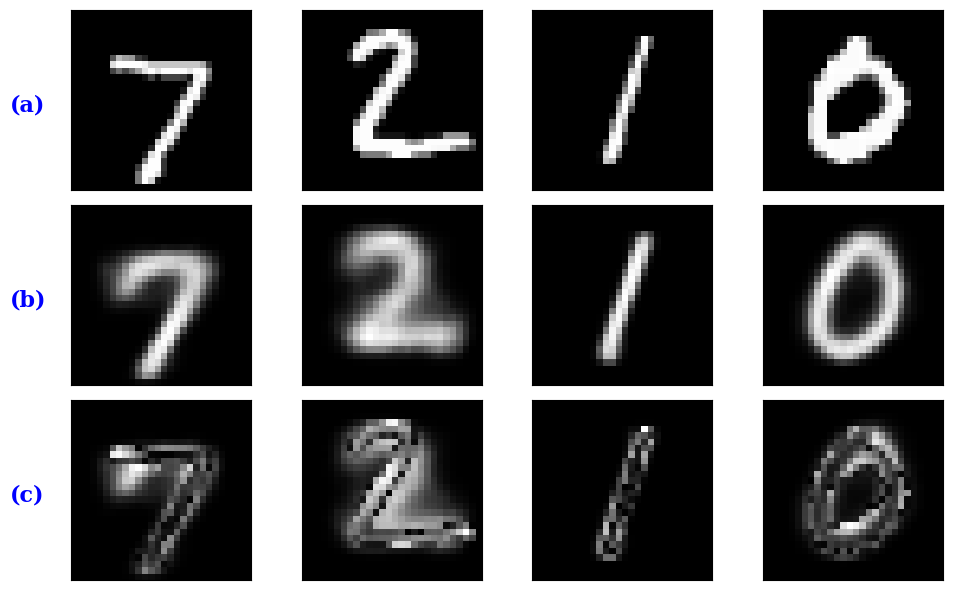

In [31]:
# Tracer et récupérer la figure
fig = plot_results(x_test_reshaped, decoded_imgs_vae)

# Optimiser l'affichage
plt.tight_layout()

# Afficher la figure
plt.show()

# Sauvegarder la figure
save_figure(fig, "Figures/Figure_7.13/Chap7_Figure_7.13")

# Comparaison Quantitative des Modèles

Erreur quadratique moyenne (MSE) pour chaque modèle:
    Auto-encodeur Simple: 0.0017
    Auto-encodeur Débruiteur: 0.0143
    Auto-encodeur Variationnel: 0.0409


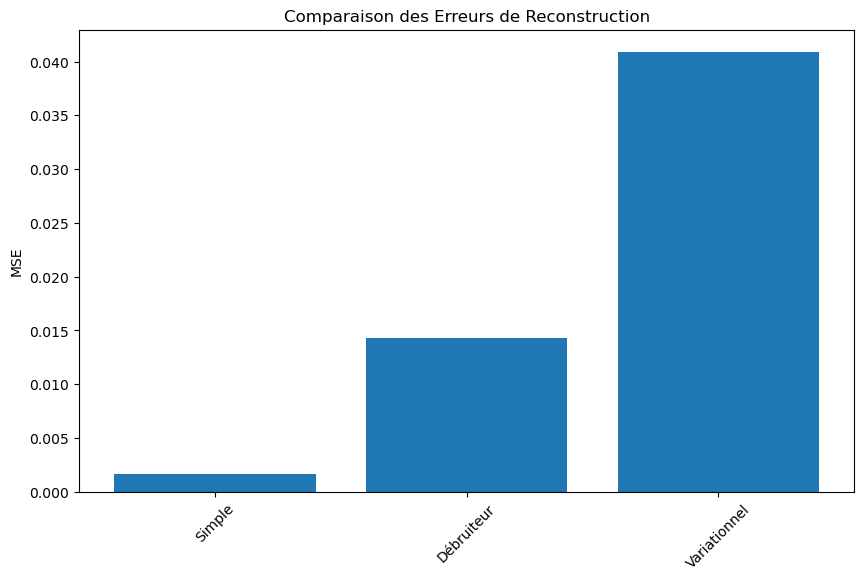


Conclusion:
Le modèle Simple présente la meilleure performance en termes d'erreur de reconstruction.

Analyse comparative:
- L'auto-encodeur simple offre une reconstruction de base acceptable.
- L'auto-encodeur débruiteur montre une bonne capacité à restaurer les images bruitées.
- L'auto-encodeur variationnel génère des reconstructions plus régularisées et peut générer de nouvelles images.


In [32]:
from sklearn.metrics import mean_squared_error

# Aplatir les tenseurs 4D en tableaux 2D
decoded_imgs_vae_flat = decoded_imgs_vae.reshape(decoded_imgs_vae.shape[0], -1)

# Calcul des erreurs de reconstruction (MSE) pour chaque modèle
mse_simple    = mean_squared_error(x_test_flat, decoded_imgs_simple)
mse_denoising = mean_squared_error(x_test_flat, decoded_imgs_denoising)
mse_vae       = mean_squared_error(x_test_flat, decoded_imgs_vae_flat)

print("Erreur quadratique moyenne (MSE) pour chaque modèle:")
print(f"    Auto-encodeur Simple: {mse_simple:.4f}")
print(f"    Auto-encodeur Débruiteur: {mse_denoising:.4f}")
print(f"    Auto-encodeur Variationnel: {mse_vae:.4f}")

# Visualisation comparative des MSE
plt.figure(figsize=(10, 6))
models = ['Simple', 'Débruiteur', 'Variationnel']
mse_values = [mse_simple, mse_denoising, mse_vae]

plt.bar(models, mse_values)
plt.title('Comparaison des Erreurs de Reconstruction')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.show()

# Analyse des résultats
best_model = models[np.argmin(mse_values)]
print(f"\nConclusion:")
print(f"Le modèle {best_model} présente la meilleure performance en termes d'erreur de reconstruction.")
print("\nAnalyse comparative:")
print("- L'auto-encodeur simple offre une reconstruction de base acceptable.")
print("- L'auto-encodeur débruiteur montre une bonne capacité à restaurer les images bruitées.")
print("- L'auto-encodeur variationnel génère des reconstructions plus régularisées et peut générer de nouvelles images.")

<hr style='border-top:4px solid #1F77B4;'>